# Rubisco DMA data

In [1]:
import os
%pylab inline
import seaborn as sns
sns.set_style('ticks')
import scipy.optimize
import scipy.constants
import scipy.special

Populating the interactive namespace from numpy and matplotlib


In [2]:
# The files have three columns: time, size, and counts. 
# In my fit, I first fitted the main peak with a Gaussian, and then used the same Gaussian but with different amplitudes 
# (given by 'guessing' a poisson parameter for droplet filling - guessing is not really correct because we know roughly droplet size and concentration)
# and progressively increasing width c(i)^2=c(1)^2*i for peak i.

In [3]:
gaussian = lambda x, A0, x0, sigma: A0*np.exp((-(x-x0)**2)/(2.*sigma**2))
gaussians = lambda x, A0s, x0s, sigmas: np.asarray([gaussian(x=x, A0=_A0, x0=_x0, sigma=_sigma) for _A0, _x0, _sigma in zip(A0s, x0s, sigmas)]).sum(axis=0)
gaussians_equal_sigmas = lambda x, A0s, x0s, sigma: np.asarray([gaussian(x=x, A0=_A0, x0=_x0, sigma=sigma) for _i, (_A0, _x0) in enumerate(zip(A0s, x0s))]).sum(axis=0)

In [8]:
# Load data
ips = [0, 2, 1]
concs_str = ['5e13', '7e14', '2e15']
concs = np.asarray([float(c) for c in concs_str]) # particles / mL
concs_M = concs * 1E3 / scipy.constants.N_A # M / L
concs_SI = concs * 1E3 * 1E3 # particles / m3

times = {}
sizes = {}
counts = {}
X = []
Y = []
for conc, ip in zip(concs_str, ips):
    fn = [os.path.join('dma_data', fn) for fn in sorted(os.listdir('dma_data')) if fn.startswith('SpR%s' % conc)][ip]
    times[conc], sizes[conc], counts[conc] = loadtxt(fn).swapaxes(0,1)
    xdata = sizes[conc]
    ydata = counts[conc]
    sel = (xdata>=10)*(xdata<=30)
    xdata = xdata[sel]
    ydata = ydata[sel]/ydata[sel].max()
    X.append(xdata)
    Y.append(ydata)
X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
poisson_prob = lambda lam, k: exp(-lam)*lam**k/scipy.special.factorial(k)

droplet_V = lambda droplet_d: 4./3.*pi*(droplet_d*1E-9/2.)**3
lam = lambda conc_SI, droplet_d: conc_SI * droplet_V(droplet_d)

A0 = lambda conc_SI, droplet_d, sigma, k: poisson_prob(lam(conc_SI, droplet_d), k)/sigma
A0s = lambda conc_SI, droplet_d, sigmas, ks: [A0(conc_SI, droplet_d, sigma, k) for k, sigma in zip(ks, sigmas)]
    
f = lambda x, n, conc_SI, droplet_d, x0, a, sigmas: gaussians(
    x,
    A0s=A0s(
        conc_SI=conc_SI,
        droplet_d=droplet_d,
        sigmas=sigmas,
        ks=range(1, n+1)
    ),
    x0s=[(x0*k**(1/a)) for k in range(1, 1+n)],
    sigmas=sigmas,
)

fs = lambda xs, n, concs_SI, droplet_d, As, x0, a, sigmas: np.asarray([A*f(x,
                                                                        n,
                                                                        conc_SI,
                                                                        droplet_d,
                                                                        x0,
                                                                        a,
                                                                        sigmas) / f(x,
                                                                                    n,
                                                                                    conc_SI,
                                                                                    droplet_d,
                                                                                    x,
                                                                                    a,
                                                                                    sigmas).max() for (x, 
                                                                                                       conc_SI,
                                                                                                       A) in zip(xs,
                                                                                                                 concs_SI,
                                                                                                                 As)])
_fs = lambda xs, concs_SI, As, n, p: fs(xs=xs,
                                    n=n,
                                    concs_SI=concs_SI,
                                    droplet_d=p[0],
                                        As=As,
                                    x0=p[1],
                                        a=p[2],
                                    sigmas=p[3:3+n],
                                   )


Guess


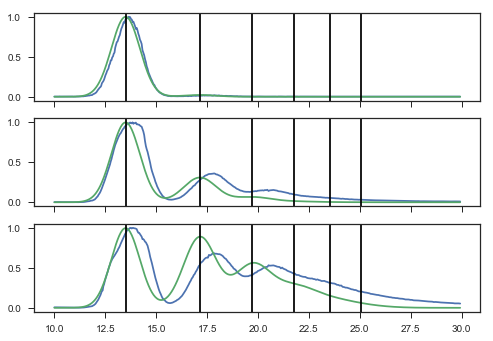

[125.02766466  13.72073366   2.56407245   0.76563679   1.07853585
   0.9989334    0.92622531   0.8524528    0.75511811]
Fit


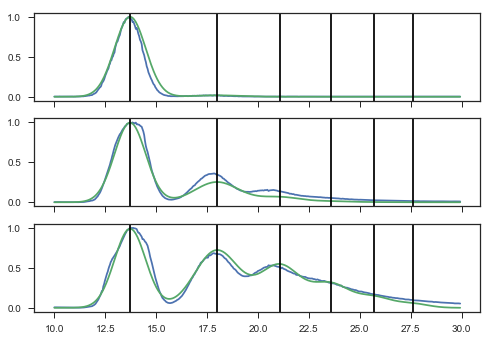

In [352]:
As = Y.max(axis=1)
sigmas_init = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2]#, 1.3]#1.0, 1.0]#, 1.0, 1.0]
n = len(sigmas_init)
x0_init = 13.5
a_init = 2.9
droplet_d_init = 124.48319653
x0s_init = asarray([(x0_init*k**(1./a_init)) for k in range(1, 1+n)])
p_init = [droplet_d_init] + [x0_init] + [a_init] + sigmas_init

err = lambda p: ((Y-_fs(xs=X, concs_SI=concs_SI, As=As, n=n, p=p))**2).sum()

Y_init = _fs(xs=X, concs_SI=concs_SI, As=As, n=n, p=p_init)

print('Guess')
fig, axs = subplots(3, 1, sharex=True)
for conc, ax, x, y, y_init in zip(concs, axs, X, Y, Y_init):
    ax.plot(x, y)
    ax.plot(x, y_init)
    for x0 in x0s_init:
        ax.axvline(x0, color='k')
show()
        
res = scipy.optimize.minimize(err, p_init)
p_fit = res.x
print(p_fit)

droplet_d_fit = p_fit[0]
x0_fit = p_fit[1]
a_fit = p_fit[2]
sigmas_fit = p_fit[3:3+n]
ps_fit = np.asarray([[poisson_prob(lam(conc_SI, droplet_d=droplet_d_fit), k) for k in range(1, 1+n)] for conc_SI in concs_SI])

x0s_fit = asarray([(x0_fit*k**(1./a_fit)) for k in range(1, 1+n)])

Y_fit = _fs(xs=X, concs_SI=concs_SI, As=As, n=n, p=res.x)

print('Fit')
fig, axs = subplots(3, 1, sharex=True)
for conc, ax, x, y, y_fit in zip(concs, axs, X, Y, Y_fit):
    ax.plot(x, y)
    ax.plot(x, y_fit)
    for x0 in x0s_fit:
        ax.axvline(x0, color='k')     

[0.76563679 1.07853585 0.9989334  0.92622531 0.8524528  0.75511811]


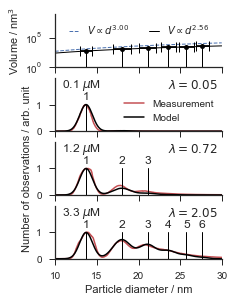

In [355]:
do_simple = False
if not do_simple:
    fig, axs = subplots(4, 1, sharex=True, figsize=(3., 4.5))
    axs_bottom = axs[1:]
else:
    fig, axs = subplots(3, 1, sharex=True, figsize=(3.5, 3.5))    
    axs_bottom = axs

for i, (conc_M, conc, ax, x, y, y_fit, p_fit) in enumerate(zip(concs_M, concs, axs_bottom, X, Y, Y_fit, ps_fit)):
    #conc_pow = int(round(log10(conc)))
    #conc_fac = conc/10**conc_pow
    ax.text(10.8, 2, '%.1f $\mu$M' % (round(conc_M*1E6, 1)), va='top')
    ax.text(29.5, 2, '$\lambda=%.2f$' % (round(lam(conc_M*scipy.constants.N_A*1E3, droplet_d=droplet_d_fit), 2)), va='top', ha='right')
    ax.plot(x, y, color='C2', lw=1.5, label='Measurement')
    ax.plot(x, y_fit, color='k', lw=1.5, label='Model')
    ax.set_yticks([0, 1])
    if i == 0:
        ax.legend(loc='lower right')
    ax.set_ylim(0, 2)
    for x0, p, k in zip(x0s_fit, p_fit, range(1, 1+n)):
        if p > 0.01:
            ax.text(x0, 1.1, k, ha='center', va='bottom')
            ax.axvline(x0, color='k', lw=1., ymin=0., ymax=1./2.)
        
    #for x0 in [(x0s_fit[0]+2.)*k**(1/3.)-2. for k in range(1, n+1)]:
    #    ax.axvline(x0, color='red')
if not do_simple:
    ax = axs[0]
    v0s_fit = 4/3.*pi*(x0s_fit/2.)**(a_fit)
    print(sigmas_fit)
    ax.set_yscale("log", nonposy='clip')
    ax.semilogy(X[0], 4/3.*pi*(X[0]/2.)**3, ls='--', lw=1., color='C0', label='$V\propto d^{3.00}$')
    ax.semilogy(X[0], 4/3.*pi*(X[0]/2.)**a_fit, ls='-', lw=1., color='k', label='$V\propto d^{%.2f}$' % round(a_fit, 2))
    ax.legend(loc='upper center', ncol=2, labelspacing=0.01, handlelength=1)
    ax.errorbar(x0s_fit, v0s_fit, fmt='.', xerr=np.asarray([sigmas_fit, sigmas_fit]),
                markersize=10, color='k', capsize=5, capthick=1.)
    for x0, v0 in zip(x0s_fit, v0s_fit):
        ax.axvline(x0, color='k', lw=1., ymin=0, ymax=log10(v0)/log10(1E9))
    ax.set_ylim(1, 1E9)
    axs[0].set_ylabel('Volume / nm$^3$')

axs[-1].set_xlabel('Particle diameter / nm')
axs[0].set_xlim(10, 30)
axs[-2].set_ylabel('Number of observations / arb. unit')

sns.despine(fig=fig)

In [349]:
a_fit

2.5640724539131954